In [1]:
!gdown --id 1NZoecSkYG-ZEGrDbmsRV50EyZb8Wv6En

Downloading...
From: https://drive.google.com/uc?id=1NZoecSkYG-ZEGrDbmsRV50EyZb8Wv6En
To: /content/shape.jpg
100% 40.4k/40.4k [00:00<00:00, 39.8MB/s]


**Canny Edge Detection Algorithm**
1. Smooth the input image with Gaussian low-pass filter
2. Compute the gradient magnitude angle images
3. Apply nonmaxima suppression to the gradient
magnitude image.
4. Use double thresholding to obtain strong and weak edge masks
5. Analyze connectivity and to detect and link edges

In [2]:
import time
from functools import wraps

def calc_time(f):
  @wraps(f)
  def wrapper(*args, **kwds):
    start = time.time()
    result = f(*args, **kwds)
    elapsed = time.time() - start
    print("%s took %ds" % (f.__name__, elapsed))
    return result
  return wrapper

In [3]:
import cv2
import numpy as np


class Convolution:
    def __init__(self):
        return None

    def correlation(self, image, kernel):
        h_image, w_image = image.shape
        h_kernel, w_kernel = kernel.shape
        h, w = h_image - h_kernel + 1, w_image - w_kernel + 1

        I = image.copy()
        return np.array([[I[i:i + w_kernel,j:j + h_kernel].ravel() @ kernel.ravel() for j in range(w)] for i in range(h)])

    def convolution(self, image, kernel):
        return self.correlation(image, np.rot90(np.rot90(kernel))) 

In [4]:
class Canny:
    def __init__(self, low=0, high=70):
        self.low = low
        self.high = high
        self.conv = Convolution()

    def smooth_with_gaussian(self, image):
        # # Using opencv function to compute
        # return cv2.GaussianBlur(image, (3, 3), 0)

        # Kernel Gaussian 3x3
        kernel = np.array([[0.0113, 0.0838, 0.0113], 
                            [0.0838, 0.6193, 0.0838],
                            [0.0113, 0.0838, 0.0113]])
        
        new_image = self.conv.convolution(image, kernel)
        return new_image

    def sobel_kernel(self, image):
        convolved = np.zeros(image.shape)        
        G_x = np.zeros(image.shape)
        G_y = np.zeros(image.shape)
        
        kernel_x = np.array(([-1, 0, 1], 
                             [-2, 0, 2], 
                             [-1, 0, 1]))
        
        kernel_y = np.array(([-1, -2, -1], 
                             [0, 0, 0], 
                             [1, 2, 1]))
        
        G_x = self.conv.correlation(image, kernel_x)
        G_y = self.conv.correlation(image, kernel_y)
        
        convolved = np.sqrt(np.square(G_x) + np.square(G_y))
        convolved = np.multiply(convolved, 255.0 / convolved.max())
        angles = np.rad2deg(np.arctan2(G_y, G_x))
        angles[angles < 0] += 180
        convolved = convolved.astype('uint8')

        return convolved, angles

    def nms(self, image, angles):
        h, w = image.shape
        suppressed = np.zeros((h, w))
        for i in range(1, h - 1):
            for j in range(1, w - 1):
                if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                    value_to_compare = max(image[i, j - 1], image[i, j + 1])
                elif (22.5 <= angles[i, j] < 67.5):
                    value_to_compare = max(image[i - 1, j - 1], image[i + 1, j + 1])
                elif (67.5 <= angles[i, j] < 112.5):
                    value_to_compare = max(image[i - 1, j], image[i + 1, j])
                else:
                    value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])                
                if image[i, j] >= value_to_compare:
                    suppressed[i, j] = image[i, j]
        suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
        return suppressed

    def double_threshold(self, image):
        weak = 50
        strong = 255
        h, w = image.shape
        result = np.zeros((h, w))
        weak_x, weak_y = np.where((image > self.low) & (image <= self.high))
        strong_x, strong_y = np.where(image >= self.high)
        result[strong_x, strong_y] = strong
        result[weak_x, weak_y] = weak
        dx = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
        dy = np.array((0, 1, 1, 1, 0, -1, -1, -1))
        
        while len(strong_x):
            x = strong_x[0]
            y = strong_y[0]
            strong_x = np.delete(strong_x, 0)
            strong_y = np.delete(strong_y, 0)
            for direction in range(len(dx)):
                new_x = x + dx[direction]
                new_y = y + dy[direction]
                if (new_x >= 0 & new_x < h & new_y >= 0 & new_y < w) and (result[new_x, new_y]  == weak):
                    result[new_x, new_y] = strong
                    np.append(strong_x, new_x)
                    np.append(strong_y, new_y)
        result[result != strong] = 0
        return result

    @calc_time
    def __call__(self, image):
        image = self.smooth_with_gaussian(image)
        image, angles = self.sobel_kernel(image)
        image = self.nms(image, angles)
        image = self.double_threshold(image)
        return image

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('shape.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Implement
canny = Canny()
image_detected = canny(image)

# OpenCV function
t1 = time.time()
edges = cv2.Canny(image, 0, 50)
t2 = time.time()
print(f'OpenCV tool {t2 - t1}s')

__call__ took 22s
OpenCV tool 0.006226539611816406s


Text(0.5, 1.0, 'Canny OpenCV')

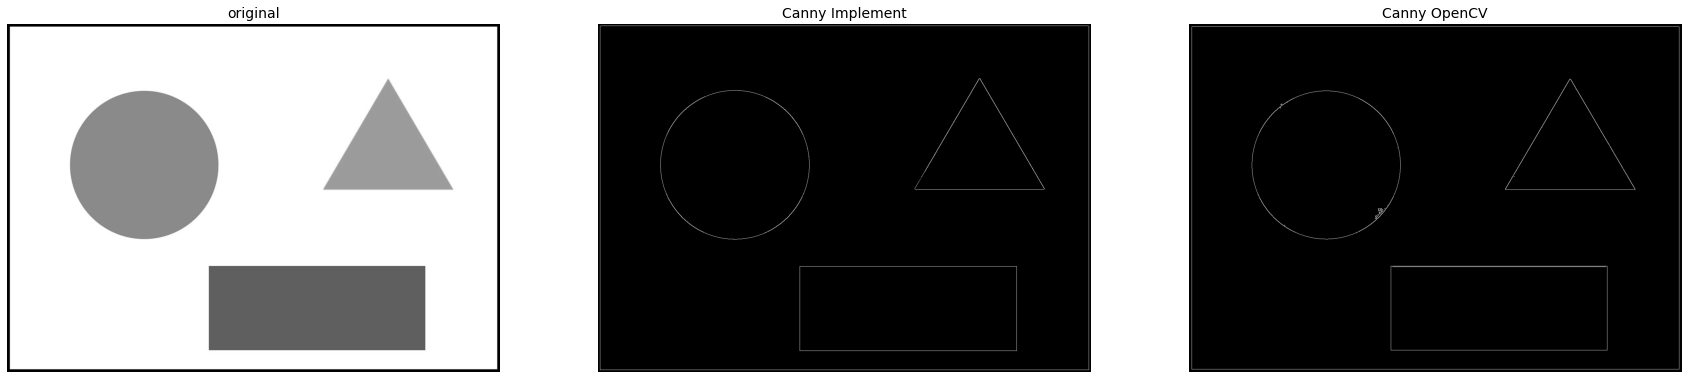

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("original", fontsize=14)

ax[1].imshow(image_detected, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Canny Implement", fontsize=14)

ax[2].imshow(edges, cmap="gray")
ax[2].axis("off")
ax[2].set_title("Canny OpenCV", fontsize=14)